In [1]:
!pip install statsmodels


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
from flexmeasures.app import create
from flexmeasures.data.models.time_series import Sensor
import plotly_express as px

from datetime import timedelta

from flexmeasures.data.utils import save_to_db

from sqlalchemy import select, update
import time

import timely_beliefs as tb
import pandas as pd
import numpy as np

from flexmeasures.data.services.utils import get_or_create_model
from flexmeasures import Asset, Sensor, AssetType, Account, Source
from flexmeasures.data.models.time_series import TimedBelief

app = create()
ctx = app.app_context()
ctx.__enter__()
session = app.db.session

[FLEXMEASURES][2025-03-26 12:08:14,880] INFO: Loading config from /home/victor/Work/Seita/flexmeasures/instance/flexmeasures.cfg ...
You might consider setting MAIL_PASSWORD.
[FLEXMEASURES][2025-03-26 12:08:14,881] INFO: [FLEXMEASURES] No SENTRY_DSN setting found, so initialising Sentry cannot happen ...
[FLEXMEASURES][2025-03-26 12:08:15,398] INFO: Importing plugin flexmeasures-entsoe ...
[FLEXMEASURES][2025-03-26 12:08:15,433] INFO: Importing plugin flexmeasures_smartbuildings ...
[FLEXMEASURES][2025-03-26 12:08:15,657] WARNING: Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).
[FLEXMEASURES][2025-03-26 12:08:15,772] INFO: Importing plugin flexmeasures_seita ...
[FLEXMEASURES][2025-03-26 12:08:15,776] INFO: Loaded plugins: {'flexmeasures-entsoe': '0.8', 'flexmeasures_smartbuildings': '0.1.0', 'flexmeasures_seita': '0.1.0'}


In [10]:
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Hourly

# Set time period
start = datetime(2025, 1, 1)
end = datetime(2025, 4, 1)
location = Point(52.37, 4.89, 70)

data = Hourly(location, start, end)
temp = data.fetch()["temp"].resample("15min").mean()

In [3]:
COP_SENSOR_ID = 236
OUTSIDE_TEMPERATURE_ID = 256
USAGE_ID=  259

In [4]:
usage = pd.DataFrame(TimedBelief.search(USAGE_ID).reset_index(
    ["belief_time", "source", "cumulative_probability"
], drop=True))
usage = usage["2025-02-20":]
usage = usage.resample("15min").mean()
usage.index = usage.index.tz_convert("UTC").tz_localize(None)
usage.describe()
usage = usage.rename(columns={"event_value" : "usage"})

In [5]:
cop = pd.DataFrame(TimedBelief.search(COP_SENSOR_ID).reset_index(
    ["belief_time", "source", "cumulative_probability"
], drop=True))
cop = cop["2025-02-20":]
#cop = cop[cop>150]
cop = cop.resample("15min").mean()
cop.index = cop.index.tz_convert("UTC").tz_localize(None)
cop.describe()
cop = cop.rename(columns={"event_value" : "COP"})

In [46]:
temp = pd.DataFrame(TimedBelief.search(OUTSIDE_TEMPERATURE_ID).reset_index(
    ["belief_time", "source", "cumulative_probability"
], drop=True))
temp = temp["2025-02-20":]
temp = temp.resample("15min").mean()
temp.index = temp.index.tz_convert("UTC").tz_localize(None)
temp.describe()
temp = temp.rename(columns={"event_value" : "temp"})

<Axes: xlabel='temp', ylabel='COP'>

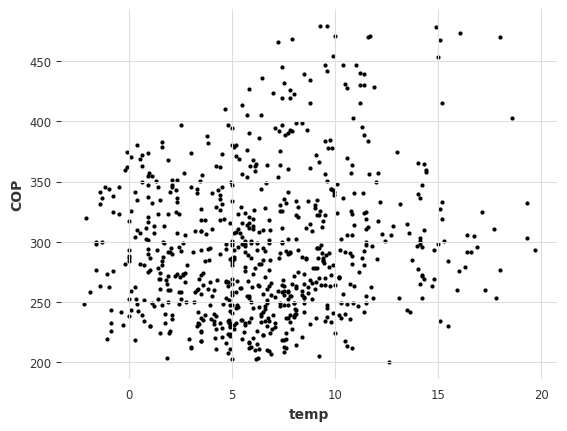

In [63]:
df = pd.concat([usage, temp, cop], axis=1).dropna()
df = df[df.usage > 15]
df = df[df.COP < 500]
df = df[df.COP > 200]
df.plot(kind="scatter", x="temp", y="COP", s=4)

<Axes: xlabel='usage', ylabel='COP'>

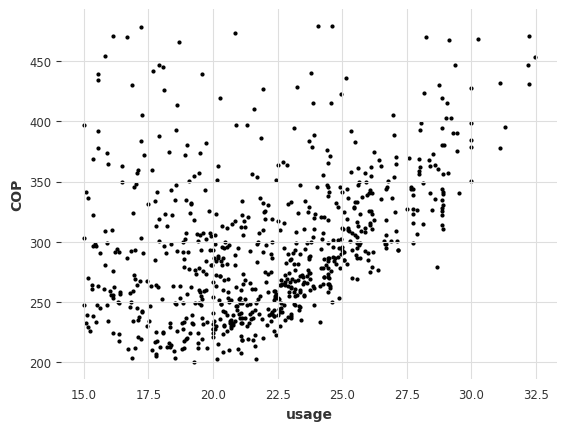

In [64]:
df.plot(kind="scatter", x="usage", y="COP", s=4)

In [65]:
import statsmodels.api as sm

mod = sm.OLS(df.COP, sm.add_constant(df[["temp", "usage"]])); 
result = mod.fit_regularized(L1_wt=0., alpha=1)
#result.summary()

In [67]:
df_daily = df.resample("15min").mean().dropna()
df_daily = df_daily[df_daily.index.dayofweek.isin([0,1,2,3,4])]
mod_d = sm.OLS(df_daily.COP, sm.add_constant(df_daily[["temp", "usage"]])); 
result_d = mod_d.fit()
result_d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    COP   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     95.22
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           5.01e-37
Time:                        12:18:23   Log-Likelihood:                -3355.5
No. Observations:                 658   AIC:                             6717.
Df Residuals:                     655   BIC:                             6730.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        145.8178     10.157     14.357      0.000     125.874     165.761
temp           0.9437      0.370      2.551      0.011       0.217       1.670
usage          6.0107      0.440     13.653      0.000       5.146       6.875
==============================================================================
Omnibus:                       52.729   Durbin-Watson:                   1.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.594
Skew:                           0.719   Prob(JB):                     1.55e-14
Kurtosis:                       3.500   Cond. No.                         152.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

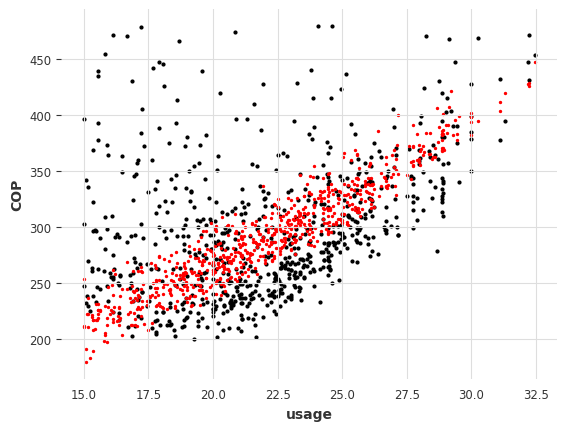

In [68]:
df.plot(kind="scatter", x="usage", y="COP", s=4)
plt.scatter(df[ "usage" ],result.predict(sm.add_constant(df[ ["temp", "usage"] ])), color="red", s=2)

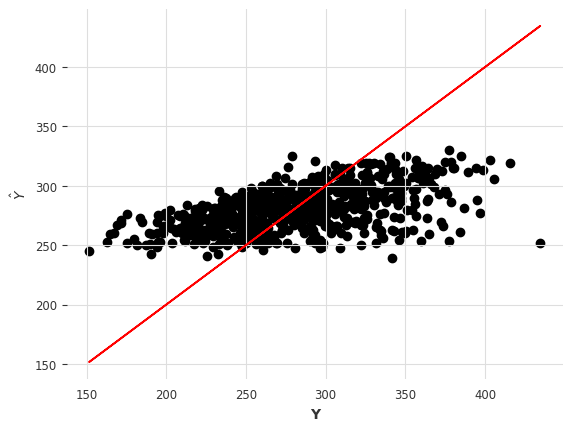

In [81]:
plt.scatter(
 df_daily.COP,
 result_d.predict(sm.add_constant(df_daily[ ["temp", "usage"] ]))
)
plt.plot(df_daily.COP, df_daily.COP, color="red")
plt.xlabel("Y")
plt.ylabel("$\hat{Y}$")
plt.show()

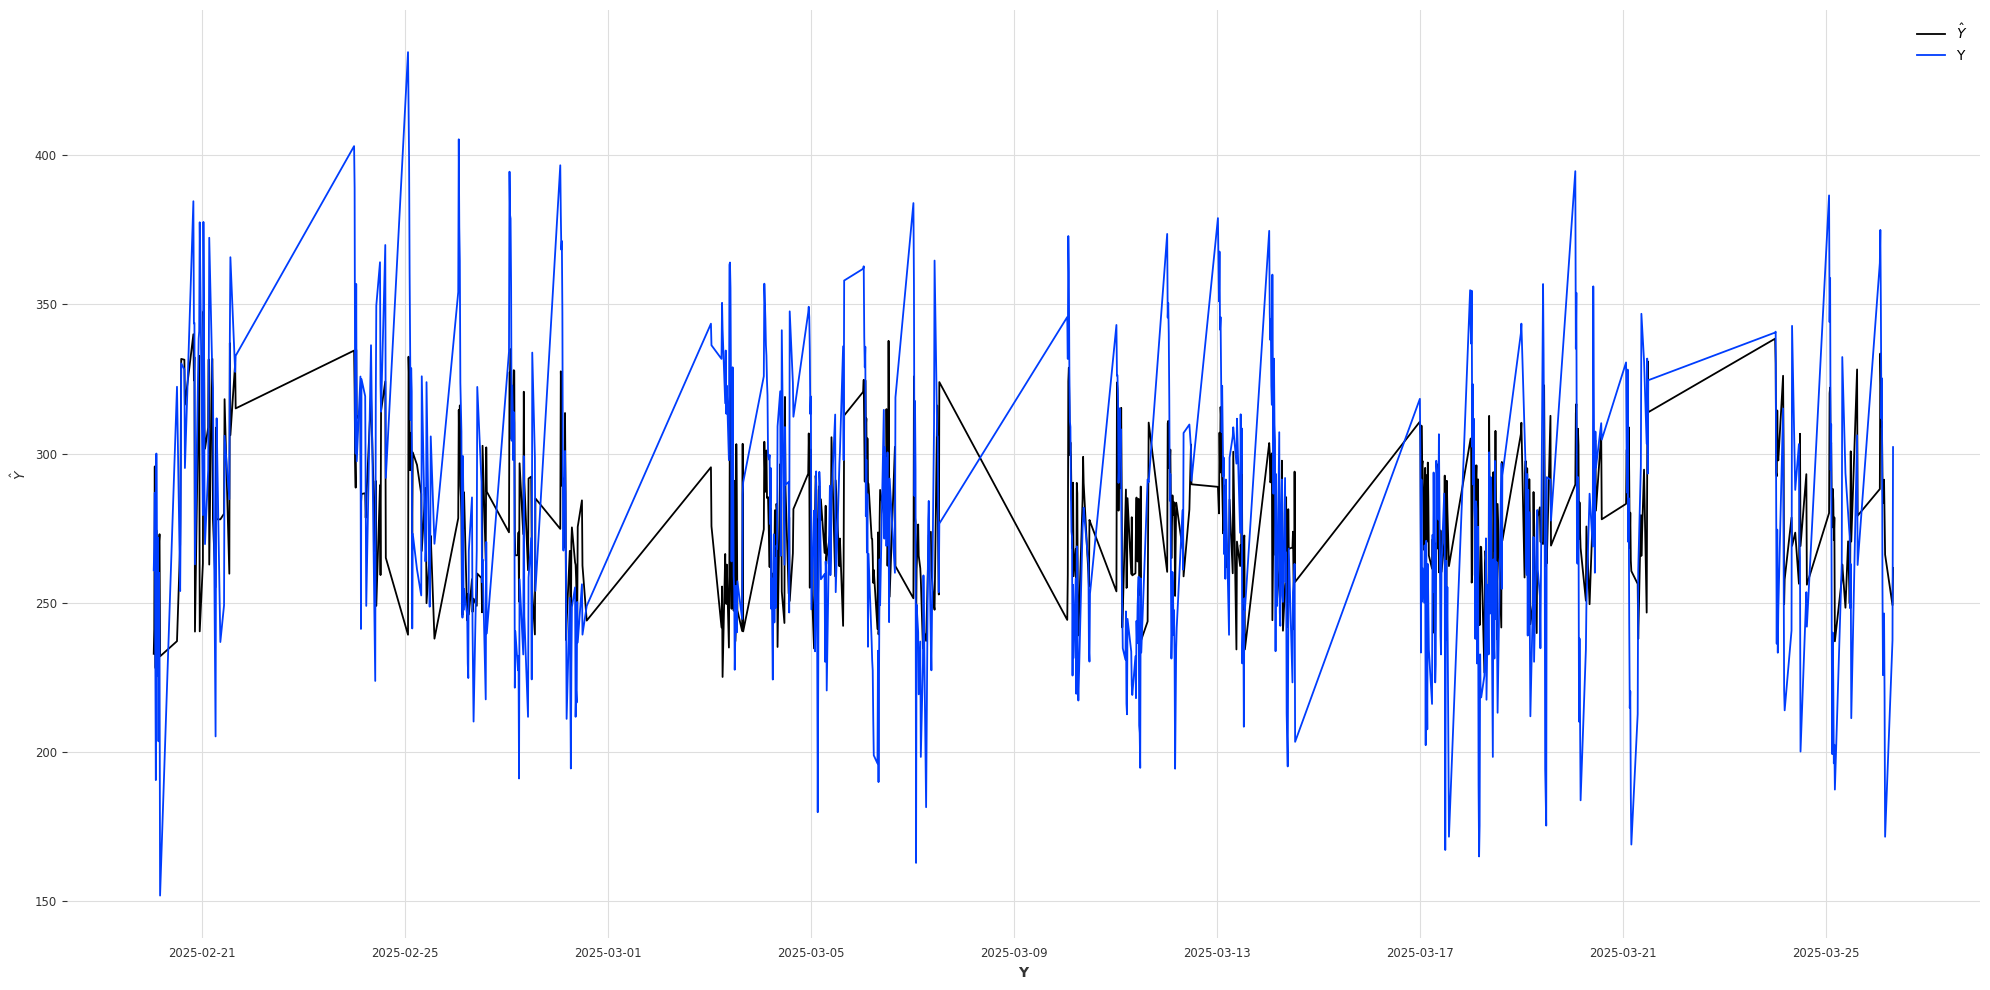

In [58]:
plt.figure(figsize=(20,10))
plt.plot(
 result_d.predict(sm.add_constant(df_daily[ ["temp", "usage"] ])), label="$\hat{Y}$"
)
plt.plot(df_daily.COP, label="Y")
plt.legend()
plt.xlabel("Y")
plt.ylabel("$\hat{Y}$")
plt.tight_layout()
plt.show()

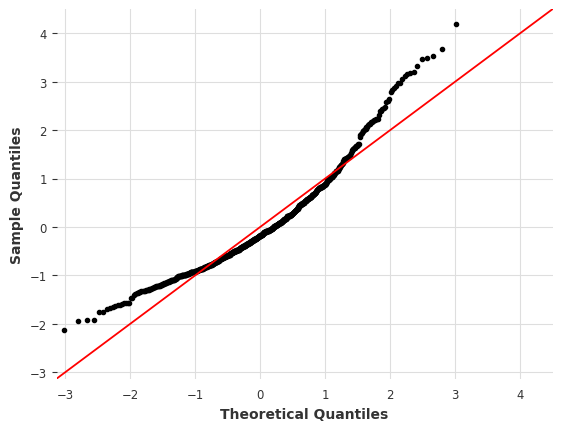

In [53]:
fig = sm.qqplot(result.resid, fit=True, line="45", ms=3)
plt.show()

<Axes: title={'center': 'COP'}, xlabel='hour'>

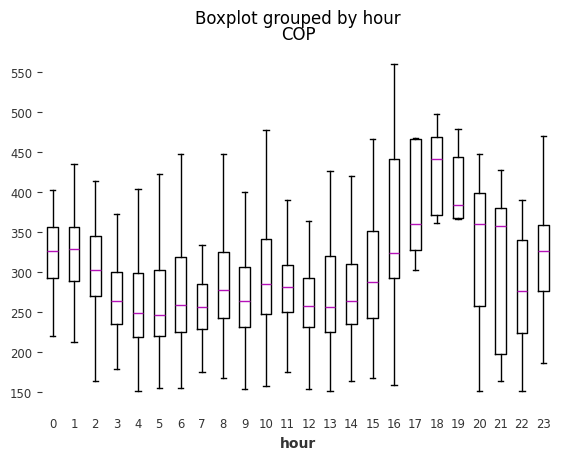

In [41]:
df["hour"] = df.index.hour

df.boxplot(column='COP', by='hour', grid=False, showfliers=False)